<a href="https://colab.research.google.com/github/sayanbanerjee32/coreference-resolution/blob/main/ULMFit_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Papers and blogs

End2End Coref Resolution By Attention RNN - https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn  
coreference-resolution - https://www.kaggle.com/abhishekbhole/coreference-resolution  
SpanBERT - https://arxiv.org/pdf/1907.10529.pdf   
BERT for Coreference Resolution - https://arxiv.org/pdf/1908.09091.pdf  
GITHub for BERT and SpanBERT - https://github.com/mandarjoshi90/coref  
Fast AI solution - https://www.kaggle.com/mamamot/fastai-awd-lstm-solution-0-71-lb/notebook  
https://www.kaggle.com/keyit92/end2end-coref-resolution-by-attention-rnn

In [1]:
%%capture
!pip install fastai -Uq

In [2]:
# mount gdrive for data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# file locations
train_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-development.tsv'
val_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-validate.tsv'
test_file_path = '/content/drive/MyDrive/coref_resolution/data/gap-test.tsv'
model_save_path = '/content/drive/MyDrive/coref_resolution/models/'

In [4]:
import pandas as pd
from fastai.text.all import *
from pathlib import Path
from tqdm.notebook import tqdm

In [5]:
train_df = pd.read_csv(train_file_path,sep="\t")
test_df = pd.read_csv(test_file_path,sep="\t")
val_df = pd.read_csv(val_file_path,sep="\t")

In [6]:
train_df["Text"][0], train_df["Text"][1]

("Zoe Telford -- played the police officer girlfriend of Simon, Maggie. Dumped by Simon in the final episode of series 1, after he slept with Jenny, and is not seen again. Phoebe Thomas played Cheryl Cassidy, Pauline's friend and also a year 11 pupil in Simon's class. Dumped her boyfriend following Simon's advice after he wouldn't have sex with her but later realised this was due to him catching crabs off her friend Pauline.",
 'He grew up in Evanston, Illinois the second oldest of five children including his brothers, Fred and Gordon and sisters, Marge (Peppy) and Marilyn. His high school days were spent at New Trier High School in Winnetka, Illinois. MacKenzie studied with Bernard Leach from 1949 to 1952. His simple, wheel-thrown functional pottery is heavily influenced by the oriental aesthetic of Shoji Hamada and Kanjiro Kawai.')

In [7]:
print(len(train_df), len(val_df), len(test_df))

2000 454 2000


## Fine tune language model

In [8]:
# lets keep val for final testing
df_pretrain = pd.concat([train_df, test_df])
df_pretrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              4000 non-null   object
 1   Text            4000 non-null   object
 2   Pronoun         4000 non-null   object
 3   Pronoun-offset  4000 non-null   int64 
 4   A               4000 non-null   object
 5   A-offset        4000 non-null   int64 
 6   A-coref         4000 non-null   bool  
 7   B               4000 non-null   object
 8   B-offset        4000 non-null   int64 
 9   B-coref         4000 non-null   bool  
 10  URL             4000 non-null   object
dtypes: bool(2), int64(3), object(6)
memory usage: 320.3+ KB


In [9]:
# fine tune language model
data_lm = DataBlock(
            blocks=TextBlock.from_df('Text', is_lm=True),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_pretrain) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj the xxunk of culture , power and gender / subject formation that xxunk xxmaj bordo 's writing arise in some degree from poststructuralist thought . xxmaj susan xxmaj xxunk points out that ` ` ( xxunk an increasing number of contemporary feminist xxunk ( bordo ) argues for a selective use of xxunk theories ' ' and one way xxmaj bordo 's work can be seen in a poststructuralist /","xxmaj the xxunk of culture , power and gender / subject formation that xxunk xxmaj bordo 's writing arise in some degree from poststructuralist thought . xxmaj susan xxmaj xxunk points out that ` ` ( xxunk an increasing number of contemporary feminist xxunk ( bordo ) argues for a selective use of xxunk theories ' ' and one way xxmaj bordo 's work can be seen in a poststructuralist / xxunk"
1,"america . xxmaj these included , xxmaj robert ` ` the xxmaj founder ' ' , xxmaj governor xxmaj william xxmaj livingston of xxmaj new xxmaj jersey and his brother xxmaj philip who was a signer of the xxmaj xxunk of xxmaj independence , xxmaj judge xxmaj robert xxup r. xxmaj livingston of xxmaj xxunk and his son , plus xxmaj edward xxmaj livingston , the friend and adviser of xxmaj andrew",". xxmaj these included , xxmaj robert ` ` the xxmaj founder ' ' , xxmaj governor xxmaj william xxmaj livingston of xxmaj new xxmaj jersey and his brother xxmaj philip who was a signer of the xxmaj xxunk of xxmaj independence , xxmaj judge xxmaj robert xxup r. xxmaj livingston of xxmaj xxunk and his son , plus xxmaj edward xxmaj livingston , the friend and adviser of xxmaj andrew xxmaj"


In [10]:
# create language model learner
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.5, pretrained=True, 
    metrics=[accuracy, Perplexity()])#.to_fp16()

SuggestedLRs(valley=0.009120108559727669)

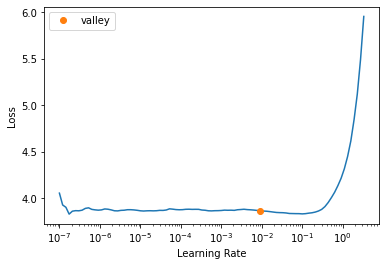

In [11]:
# find optimum learning rate for language model
learn_lm.lr_find()

In [12]:
# one cycle training
learn_lm.fit_one_cycle(1, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.723886,3.487710,0.367894,32.710938,00:18


In [13]:
# unfreeze all the layers and one cycle training
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, 0.003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.428385,3.459268,0.360218,31.793697,00:20
1,3.256219,3.350763,0.379793,28.524479,00:20
2,2.922179,3.362119,0.373301,28.850258,00:24
3,2.510105,3.416416,0.375915,30.460041,00:20
4,2.217802,3.492610,0.372976,32.871613,00:20


In [14]:
# save language model
learn_lm.save(Path(model_save_path) /'lm_fine_tuned')
learn_lm.save_encoder(Path(model_save_path) /'lm_fine_tuned_encoder')

In [15]:
# load pre-trained language model
# learn_lm_pretrained = load_learner(Path(model_save_path)/'lm_fine_tuned.pth', cpu = False)
# learn_lm.load(Path(model_save_path) /'lm_fine_tuned')

In [16]:
vocab = learn_lm.dls
# vocab.numericalize(tokenizer(train_df["Text"][0]))

## Pre-process data

In [17]:
import torch
from torch.utils.data import Dataset, TensorDataset

In [18]:
spacy_tok = SpacyTokenizer("en")
tokenizer = Tokenizer(spacy_tok)

In [19]:
# train_df["Text"][0], tokenizer(train_df["Text"][0])

In [20]:
import spacy
nlp = spacy.blank("en")

# note that 'xxunk' is not special in this sense
# special_tokens = ['xxbos','xxfld','xxpad', 'xxmaj','xxup','xxrep','xxwrep']

special_tokens = ['xxpad']

def get_token_num_by_offset(s, offset):
  s_pre = s[:offset]
  return len(tokenizer(s_pre))
  # return len([t for t in tokenizer(s_pre) if t not in special_tokens])


def adjust_token_num(processed, token_num):
  """
  As fastai tokenizer introduces additional tokens, we need to adjust for them.
  """
  counter = -1
  do_unrep = None
  for i, token in enumerate(processed):
    if token not in special_tokens:
      counter += 1
    # if do_unrep:
    #   do_unrep = False
    #   if processed[i+1] != ".":
    #     token_num -= (int(token) - 2) # one to account for the num itself
    #   else:  # spacy doesn't split full stops
    #     token_num += 1
    # if token == "xxrep":
    #   do_unrep = True
    if counter == token_num:
      return i
  else: # else for 'for'
    counter2 = -1
    for j, t in enumerate(processed):
      if t not in special_tokens:
        counter2 += 1
      # print(j, counter, t)
    raise Exception(f"{token_num} is out of bounds ({processed})")

In [21]:
import traceback
def dataframe_to_tensors(df, max_len=512):
  # offsets are: pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset
  offsets = list()
  labels = np.zeros((len(df),), dtype=np.int64)
  processed = list()
  for i, row in tqdm(df.iterrows()):
    try:
      text = row["Text"]
      a_offset = row["A-offset"]
      a_len = len(nlp(row["A"]))
      
      b_offset = row["B-offset"]
      b_len = len(nlp(row["B"]))

      pron_offset = row["Pronoun-offset"]
      is_a = row["A-coref"]
      is_b = row["B-coref"]
      a_tok_offset = get_token_num_by_offset(text, a_offset)
      b_tok_offset = get_token_num_by_offset(text, b_offset)
      a_right_offset = a_tok_offset + a_len - 1
      b_right_offset = b_tok_offset + b_len - 1
      pron_tok_offset = get_token_num_by_offset(text, pron_offset)
      tokenized = tokenizer(text)[:max_len]
      tokenized = ["xxpad"] * (max_len - len(tokenized))  + tokenized # add padding
      a_tok_offset = adjust_token_num(tokenized, a_tok_offset)
      a_tok_right_offset = adjust_token_num(tokenized, a_right_offset)
      b_tok_offset = adjust_token_num(tokenized, b_tok_offset)
      b_tok_right_offset = adjust_token_num(tokenized, b_right_offset)
      pron_tok_offset = adjust_token_num(tokenized, pron_tok_offset)
      numericalized = vocab.numericalize(tokenized)
      processed.append(torch.tensor(numericalized, dtype=torch.long))
      offsets.append([pron_tok_offset, a_tok_offset, a_tok_right_offset, b_tok_offset, b_tok_right_offset])
      if is_a:
        labels[i] = 0
      elif is_b:
        labels[i] = 1
      else:
        labels[i] = 2
    except Exception as e:
      print(i)
      traceback.print_exc()
      raise
  processed = torch.stack(processed)
  offsets = torch.tensor(offsets, dtype=torch.long)
  labels = torch.from_numpy(labels)
  return processed, offsets, labels

In [22]:
train_ds = TensorDataset(*dataframe_to_tensors(train_df))
valid_ds = TensorDataset(*dataframe_to_tensors(val_df))
test_ds = TensorDataset(*dataframe_to_tensors(test_df))

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [23]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

### Classifier

In [24]:
learn_lm.freeze()

In [40]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim 
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [25]:
encoder_hidden_sz = 400

device = torch.device("cuda")

class CorefResolver(nn.Module):
  def __init__(self, encoder, dropout_p=0.3):
    super(CorefResolver, self).__init__()
    self.encoder = encoder
    self.dropout = nn.Dropout(dropout_p)
    self.hidden2hidden = nn.Linear(encoder_hidden_sz * 2 + 1, 25)
    self.hidden2logits = nn.Linear(50, 3)
    self.relu = nn.ReLU()
    self.activation = nn.LogSoftmax(dim=1)
    self.loss = nn.NLLLoss()
    
  def forward(self, seqs, offsets, labels=None):
    encoded = self.dropout(self.encoder(seqs)) #[0][2])
    a_q = list()
    b_q = list()
    for enc, offs in zip(encoded, offsets):
      # extract the hidden states that correspond to A, B and the pronoun, and make pairs of those 
      a_repr = enc[offs[2]]
      b_repr = enc[offs[4]]
      a_q.append(torch.cat([enc[offs[0]], a_repr, torch.dot(enc[offs[0]], a_repr).unsqueeze(0)]))
      b_q.append(torch.cat([enc[offs[0]], b_repr, torch.dot(enc[offs[0]], b_repr).unsqueeze(0)]))
    a_q = torch.stack(a_q)
    b_q = torch.stack(b_q)
    # apply the same "detector" layer to both batches of pairs
    is_a = self.relu(self.dropout(self.hidden2hidden(a_q)))
    is_b = self.relu(self.dropout(self.hidden2hidden(b_q)))
    # concatenate outputs of the "detector" layer to get the final probability distribution
    is_a_b = torch.cat([is_a, is_b], dim=1)
    is_logits = self.hidden2logits(self.dropout(self.relu(is_a_b)))

    activation = self.activation(is_logits)
    if labels is not None:
      return activation, self.loss(activation, labels)
    else:
      return activation

In [26]:
enc = learn_lm.model[0]

In [27]:
resolver = CorefResolver(enc)

In [28]:
resolver.to(device)

CorefResolver(
  (encoder): AWD_LSTM(
    (encoder): Embedding(10592, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(10592, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (hidden2hidden): Linear(in_features=801, out_features=25, bias=True)
  (hidden2logits): Linear(in_features=50, out_features=3, bias=True)
  (relu): ReLU()
  (activation): LogSoftmax(dim=1)
  (loss): NLLLoss()
)

In [29]:
for param in resolver.encoder.parameters():
  param.requires_grad = False

In [30]:
lr = 0.001

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(resolver.parameters(), lr=lr)

In [31]:
from sklearn.metrics import classification_report

In [32]:
def train_epoch(model, optimizer, train_dl, report_every=10):
  model.train()
  step = 0
  total_loss = 0
  
  for texts, offsets, labels in train_dl:
    texts, offsets, labels = texts.to(device), offsets.to(device), labels.to(device)
    step += 1
    optimizer.zero_grad()
    _, loss = model(texts, offsets, labels)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    if step % report_every == 0:
      print(f"Step {step}, loss: {total_loss/report_every}")
      total_loss = 0
      
def evaluate(model, optimizer, valid_dl, probas=False):
  probas = list()
  model.eval()
  predictions = list()
  total_loss = 0
  all_labels = list()
  with torch.no_grad():
    for texts, offsets, labels in valid_dl:
      texts, offsets, labels = texts.cuda(), offsets.cuda(), labels.cuda()
      preds, loss = model(texts, offsets, labels)
      total_loss += loss.item()
      probas.append(preds.cpu().detach().numpy())
      predictions.extend([i.item() for i in preds.max(1)[1]])
    
    
  print(f"Validation loss: {total_loss/len(valid_dl)}")
  print()
  print(classification_report(valid_dl.dataset.tensors[2].numpy(), predictions))
  if probas:
    return total_loss, np.vstack(probas)
  return total_loss, predictions

In [33]:
total_epoch = 0
best_loss = 1e6

for i in range(10):
  print("Epoch", i + 1)
  total_epoch += 1
  train_epoch(resolver, optimizer, train_dl) 
  loss, labels = evaluate(resolver, optimizer, test_dl)
  if loss < best_loss:
    best_loss = loss
    print(f"Loss improved, saving {total_epoch}")
    torch.save(resolver.state_dict(), Path(model_save_path)/"model_best.pt")

Epoch 1
Step 10, loss: 1.0401509761810304
Step 20, loss: 0.948426079750061
Step 30, loss: 0.9589427173137665
Validation loss: 0.9032026046798343

              precision    recall  f1-score   support

           0       0.65      0.54      0.59       918
           1       0.55      0.80      0.65       855
           2       0.00      0.00      0.00       227

    accuracy                           0.59      2000
   macro avg       0.40      0.45      0.41      2000
weighted avg       0.53      0.59      0.55      2000

Loss improved, saving 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2
Step 10, loss: 0.8815369486808777
Step 20, loss: 0.8818525552749634
Step 30, loss: 0.8737873017787934
Validation loss: 0.8515901991299221

              precision    recall  f1-score   support

           0       0.69      0.61      0.64       918
           1       0.59      0.82      0.68       855
           2       0.00      0.00      0.00       227

    accuracy                           0.63      2000
   macro avg       0.42      0.47      0.44      2000
weighted avg       0.57      0.63      0.59      2000

Loss improved, saving 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3
Step 10, loss: 0.8382871627807618
Step 20, loss: 0.8651101410388946
Step 30, loss: 0.8135604918003082
Validation loss: 0.8196156223615011

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       918
           1       0.61      0.82      0.70       855
           2       0.00      0.00      0.00       227

    accuracy                           0.65      2000
   macro avg       0.43      0.49      0.46      2000
weighted avg       0.58      0.65      0.60      2000

Loss improved, saving 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4
Step 10, loss: 0.8241340339183807
Step 20, loss: 0.7857409060001374
Step 30, loss: 0.7709757089614868
Validation loss: 0.8042920581878178

              precision    recall  f1-score   support

           0       0.70      0.64      0.67       918
           1       0.61      0.83      0.70       855
           2       0.00      0.00      0.00       227

    accuracy                           0.65      2000
   macro avg       0.44      0.49      0.46      2000
weighted avg       0.58      0.65      0.61      2000

Loss improved, saving 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5
Step 10, loss: 0.7732559442520142
Step 20, loss: 0.789754182100296
Step 30, loss: 0.7720060825347901
Validation loss: 0.7922703226407369

              precision    recall  f1-score   support

           0       0.72      0.63      0.67       918
           1       0.61      0.85      0.71       855
           2       0.00      0.00      0.00       227

    accuracy                           0.65      2000
   macro avg       0.44      0.49      0.46      2000
weighted avg       0.59      0.65      0.61      2000

Loss improved, saving 5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 6
Step 10, loss: 0.7709351301193237
Step 20, loss: 0.7536661028862
Step 30, loss: 0.7358182430267334
Validation loss: 0.7722865494470748

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       918
           1       0.62      0.83      0.71       855
           2       1.00      0.00      0.01       227

    accuracy                           0.66      2000
   macro avg       0.78      0.50      0.47      2000
weighted avg       0.71      0.66      0.62      2000

Loss improved, saving 6
Epoch 7
Step 10, loss: 0.7477600038051605
Step 20, loss: 0.7591916084289551
Step 30, loss: 0.7467046916484833
Validation loss: 0.7643469581528316

              precision    recall  f1-score   support

           0       0.71      0.69      0.70       918
           1       0.63      0.82      0.71       855
           2       1.00      0.00      0.01       227

    accuracy                           0.66      2000
   macro avg       0.78      0.5

## Test

In [34]:
loss, res = evaluate(resolver, optimizer, valid_dl, True)
res_s = np.exp(res)  # don't forget that we have log-softmax outputs:
test_res = pd.DataFrame(res_s, index=val_df["ID"], columns=["A", "B", "NEITHER"])
test_res.head()

Validation loss: 0.8265786091486613

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       187
           1       0.67      0.69      0.68       205
           2       1.00      0.02      0.03        62

    accuracy                           0.64       454
   macro avg       0.76      0.50      0.47       454
weighted avg       0.69      0.64      0.60       454



,A,B,NEITHER
ID,,,
validation-1,0.268204,0.617608,0.114189
validation-2,0.568593,0.272469,0.158939
validation-3,0.142309,0.775550,0.082141
validation-4,0.555599,0.256977,0.187425
validation-5,0.828078,0.104330,0.067592


In [35]:
val_df.head()

,ID,Text,Pronoun,Pronoun-offset,A,A-offset,A-coref,B,B-offset,B-coref,URL
0,validation-1,"He admitted making four trips to China and playing golf there. He also admitted that ZTE officials, whom he says are his golf buddies, hosted and paid for the trips. Jose de Venecia III, son of House Speaker Jose de Venecia Jr, alleged that Abalos offered him US$10 million to withdraw his proposal on the NBN project.",him,256,Jose de Venecia Jr,208,False,Abalos,241,False,http://en.wikipedia.org/wiki/Commission_on_Elections_(Philippines)
1,validation-2,"Kathleen Nott was born in Camberwell, London. Her father, Philip, was a lithographic printer, and her mother, Ellen, ran a boarding house in Brixton; Kathleen was their third daughter. She was educated at Mary Datchelor Girls' School (now closed), London, before attending King's College, London.",She,185,Ellen,110,False,Kathleen,150,True,http://en.wikipedia.org/wiki/Kathleen_Nott
2,validation-3,"When she returns to her hotel room, a Liberian man (Tony Todd) forces her to smuggle $20 million worth of conflict diamonds to New York, or else fellow fight attendant and friend Angela will die. She is caught before she can board the flight, and the team now have nine hours until the plane lands, and save Angela. After the confiscated diamonds are stolen by the brother of Kaleo (Jason Scott Lee), whom Danny put away for murdering his partner last year, Five-0 and Chief Fryer team up and enlist the help of August March (Ed Asner), who served a 30-year sentence for smuggling diamonds.",his,435,Jason Scott Lee,383,False,Danny,406,True,"http://en.wikipedia.org/wiki/Hawaii_Five-0_(2010_TV_series,_season_2)"
3,validation-4,"On 19 March 2007, during a campaign appearance for the New South Wales State Election, the then opposition leader Peter Debnam was confronted by Reucassel wearing nothing but Speedos and a baseball cap, making fun of Debnam's campaign appearances in the swimwear. When TV cameras remained focused on Reucassel rather than Mr Debnam, he said, ``Sorry, I'm not Peter Debnam, he's over there.",he,333,Reucassel,300,True,Debnam,325,False,http://en.wikipedia.org/wiki/Craig_Reucassel
4,validation-5,"By this time, Karen Blixen had separated from her husband, and after their divorce in 1925, Finch Hatton moved into her house and began leading safaris for wealthy sportsmen. Among his clients were Marshall Field Jr and Edward, Prince of Wales. According to the author Mary Lovell, in 1930 Finch Hatton began a love affair with Beryl Markham, who was working as a race-horse trainer in Nairobi and the surrounding area. Later, she would become known as a pioneer flyer herself (Markham attributed her interest in flying to her association with Tom Campbell Black).",she,427,Finch Hatton,290,False,Beryl Markham,328,True,http://en.wikipedia.org/wiki/Denys_Finch_Hatton
